In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from art_functions import *
import random as rand


In [ ]:
width, height = 400, 700

In [ ]:
# canvas = np.zeros((width,height),dtype=int)
# print(canvas.shape)

In [2]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [308]:
def curved_line_horizontal(x0, x1, y0, x_spread=4, y_spread=20, num_points=0):
    if num_points == 0:
        num_points = np.random.randint(3,6) * 2
    
    ### get x points
    x = np.linspace(x0,x1,num_points)
    for i in range(len(x)):
        x[i] += rand.randint(-x_spread,x_spread)
    x[0], x[-1] = x0, x1
    
    ### get y points
    y = np.full(num_points, y0)
    for i in range(len(y)):
        y[i] += rand.randint(-y_spread,y_spread)
    y[0], y[-1] = y0, y0

    ### interpolate
    line_res = 5
    x2 = np.linspace(x[0], x[-1], (x[-1] - x[0])*line_res)
    x2, indices = np.unique(x2, return_index=True)
    y2 = interpolate.pchip_interpolate(x, y, x2[indices])
    
    return x2, y2

In [309]:
def curved_line_vertical(x0, y0, y1, y_spread=2, num_points=0):    
    x1new = x0 + (y1 - y0)
    
    ### something funny here, y coordinate is y0, not between y0 and y1
    hx, hy = curved_line_horizontal(x0, x1new, y0, y_spread=y_spread)
    vx, vy = [], []
    for i in range(len(hx)-1):
        coord = rotate((x0, y0),(hx[i],hy[i]),math.radians(90))
        vx.append(coord[0])
        vy.append(coord[1]) 
    return vx, vy

In [310]:
def quantize_line_pair(x, y):
    horizontal = True
    if len(np.unique(np.vectorize(round)(x)).astype(int)) < len(np.unique(np.vectorize(round)(y)).astype(int)):
        horizontal = False
    
    if horizontal:
        x_int = (np.vectorize(round)(x)).astype(int)
        x_diff = np.diff(x_int)
        x_ints = np.concatenate(np.argwhere(x_diff==1))
        x_uni = x_int[x_ints]
        y_uni = (np.vectorize(round)(y)).astype(int)[x_ints]
    else:
        y_int = (np.vectorize(round)(y)).astype(int)
        y_diff = np.diff(y_int)
        y_ints = np.concatenate(np.argwhere(y_diff==1))
        y_uni = y_int[y_ints]
        x_uni = (np.vectorize(round)(x)).astype(int)[y_ints]
        
    return x_uni, y_uni

In [311]:
def get_rectangle_curved(w0, h0, w1, h1):
    tx, ty = curved_line_horizontal( w0, w1, h0, y_spread=5)
    bx, by = curved_line_horizontal( w0, w1, h1, y_spread=5)
    lx, ly = curved_line_vertical( w0, h0, h1, y_spread=3)
    rx, ry = curved_line_vertical( w1, h0, h1, y_spread=3)

    tx = np.asarray(tx)
    ty = np.asarray(ty)
    tx, ty = quantize_line_pair(tx, ty)
    
    bx = np.asarray(bx)
    by = np.asarray(by)
    bx, by = quantize_line_pair(bx, by)
    
    lx = np.asarray(lx)
    ly = np.asarray(ly)
    lx, ly = quantize_line_pair(lx, ly)
    
    rx = np.asarray(rx)
    ry = np.asarray(ry)
    rx, ry = quantize_line_pair(rx, ry)
    
    return tx, ty, bx, by, lx, ly, rx, ry

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


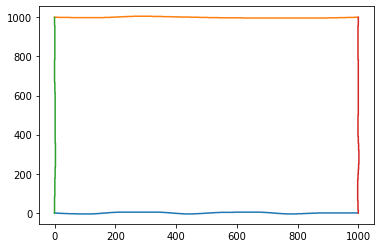

In [312]:
w, h = 400, 600

q,w,e,r,t,y,u,i = get_rectangle_curved(0, 0, 1000, 1000)

plt.plot(q,w)
plt.plot(e,r)
plt.plot(t,y)
plt.plot(u,i)

In [284]:
def array_distances(np_array, req_dist):
    diffs = np.diff(np_array)
    if (len(np_array) == 1) | (np.all(diffs > req_dist)):
        return True
    else:
        return False
    
def get_rectangle_set(width_full, height_full, num_rect, border=0.05):
    num_rect -= 1
    
    spacing = 15
    rect_centers = np.array([15,16]) #dummy value
    
    while not array_distances(rect_centers, spacing):
        rect_centers = np.random.randint(spacing, (100 - spacing), num_rect)
        rect_centers.sort()
        
    rect_centers = np.insert(rect_centers, 0, 0)
    rect_centers = np.append(rect_centers, 100)
    
    rect_set = []
    for i in range(len(rect_centers) - 1):
        rect_bottom = (rect_centers[i] * height_full / 100) + (height_full * border/num_rect)
        rect_top = ((rect_centers[i + 1]) * height_full / 100) - (height_full * border/num_rect)
        rect_left = width_full * border
        rect_right = width_full * (1 - border)
        rect_set.append(get_rectangle_curved(rect_left, rect_bottom, rect_right, rect_top))
        
    return rect_set

In [285]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

In [299]:
def mark_rothko(width, height, num_squares=2):
    canvas = np.zeros((width,height),dtype=int)
    print(canvas.shape)

    rects = get_rectangle_set(width, height, num_squares)
    
    color = 1
    for r in rects: #t, b, l, r

        bx, by, tx, ty, lx, ly, rx, ry = r[0], r[1], r[2], r[3], r[4], r[5], r[6], r[7]
        
        b_min = int(np.floor(min(by)))
        b_max = int(np.ceil(max(by)))
        t_min = int(np.floor(min(ty)))
        t_max = int(np.ceil(max(ty)))
        
        l_min = int(np.floor(min(lx)))
        l_max = int(np.ceil(max(lx)))
        r_min = int(np.floor(min(rx)))
        r_max = int(np.ceil(max(rx)))
        
        # middle
        for i in range(l_max, r_min):
            for j in range(b_max, t_min):
                canvas[i][j] = color
                
        # horizontal
        for i in range(len(bx)-1):    
            ### top
            for j in range(b_min, b_max):
                if j >= by[i]:
                    canvas[i + int(bx[0])][j] = color
            ### bottom
            for j in range(t_min, t_max):
                if j <= ty[i]:
                    canvas[i + int(tx[0])][j] = color
                       
        # vertical
        for j in range(len(ly)-1): 
            # left
            for i in range(l_min, l_max + 1):
                if i >= lx[j]:
                    canvas[i][j + ly[0]] = color 
            # right
            for i in range(r_min, r_max + 1):
                if i <= rx[j]:
                    canvas[i][j + ry[0]] = color 
            
            
            
        
        color += 1

    return canvas

(400, 600)


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


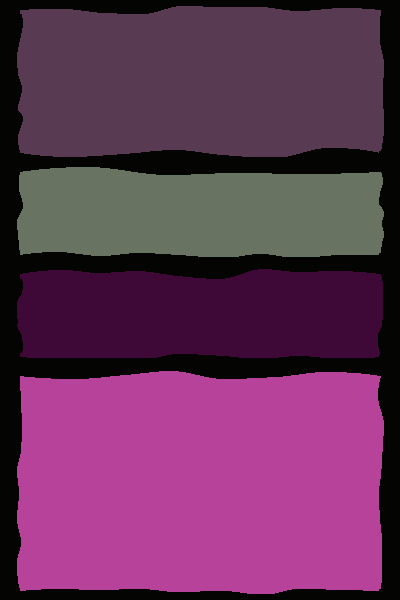

In [318]:
canvas_to_image(mark_rothko(400,600,4))

In [ ]:
w, h = 1000, 1000
border_width = .05

q,w,e,r,t,y,u,i = get_rectangle_curved(w, h)

plt.plot(q,w)
plt.plot(e,r)
plt.plot(t,y)
plt.plot(u,i)

In [ ]:
def curved_line_vertical(x0, y0, x1, y1, border=.05, x_spread=4, y_spread=20, num_points=0):
    print('v points: ', x0, y0, x1, y1)
#     center = ((x0),((y1 - y0)/2) + y0)
    
    ynew = ((y1-y0)/2) + y0
    x0r = (ynew - ((y1-y0)/2)) * (1 - border)
    x1r = ynew + ((y1-y0)/2) * (1 + border)
    
    
    print('  start: ',int(x0r), int(ynew))
    print('  end:   ',int(x1r), int(ynew))
    ### something funny here, y coordinate is y0, not between y0 and y1
    hx, hy = curved_line_horizontal(x0r, ynew, x1r, ynew, y_spread=y_spread)
    vx, vy = [], []
    for i in range(len(hx)-1):
        coord = rotate((x0r, ynew),(hx[i],hy[i]),math.radians(-90))
        vx.append(coord[0])
        vy.append(coord[1]+ ynew) 
    return vx, vy

In [ ]:
s = [20, 17, 15, 12, 24, 19, 17, 15]
sub_line = 0
ascending = True

order = ''
if s[0] < s[1]:
    order = 'asc'
else:
    order = 'des'

cur_list = []
sub_lists = []
    
for i in range(len(s) -1):
    cur_order = ''
    cur_list.append(s[i])
    
    if s[i] < s[i + 1]:
        cur_order = 'asc'
    else:
        cur_order = 'des'
        
    if cur_order == order:
        print('same')
    else:
        print('not same: ', sub_lists, cur_list)
        sub_lists.append(cur_list)
        cur_list = [s[i]]
        
    print(i, order, cur_order, cur_list)
    order = cur_order
    
print(sub_lists)

In [ ]:
def paint_splat(canvas, color):
    num_points = np.random.randint(3,6)
    splat_width = 4
    splat_height = 20
    
    x = np.random.randint(0,canvas.shape[0],size=num_points)
    while (min(abs(np.ediff1d(x))) < 20) | (max(x) - min(x) <= ((splat_width + 1) * num_points)) | (x.shape[0] != np.unique(x).shape[0]) | (x[1] - x[0] <= splat_width) | (x[-1] - x[-2] <= splat_width):
        x = np.random.randint(0,canvas.shape[0],size=num_points)
    x.sort()
    y = np.random.randint(0,canvas.shape[1],size=num_points)
    
    v, w = x.copy(), y.copy()
    
    for i in range(num_points - 2):
        v_temp = v[i + 1] + random.randint(-splat_width, splat_width)
        while v_temp in v:
            v_temp = v[i + 1] + random.randint(-splat_width, splat_width)
        v[i + 1,] = min(max(v_temp,0),canvas.shape[0]-1)
        w[i + 1,] += min(max(random.randint(-splat_height, splat_height),0),canvas.shape[1]-1)
    v.sort()
        

    line_res = 5
    x2 = np.linspace(x[0], x[-1], (x[-1] - x[0])*line_res)
    x2, indices = np.unique(x2, return_index=True)
    y2 = interpolate.pchip_interpolate(x, y, x2[indices])
    
    v2 = np.linspace(v[0], v[-1], (v[-1] - v[0])*line_res)
    v2, indices = np.unique(v2, return_index=True)
    w2 = interpolate.pchip_interpolate(v, w, v2[indices])
    
    
    #do splatter
    for i in range(len(x2)):
        if y2[i] < canvas.shape[1]:
            canvas[int(math.ceil(x2[i]))][int(math.ceil(y2[i]))] = color
        canvas[int(math.floor(x2[i]))][int(math.floor(y2[i]))] = color
        
        if (v2[i] >= 0) & (w2[i] >= 0) & (v2[i] < canvas.shape[0]) & (w2[i] < canvas.shape[1] - 1):
            canvas[int(math.ceil(v2[i]))][int(math.ceil(w2[i]))] = color
            canvas[int(math.floor(v2[i]))][int(math.floor(w2[i]))] = color
        
        
        
def cy_twombly(width, height, num_colors, num_splatters):
    canvas = np.zeros((width,height),dtype=int)
    print(canvas.shape)

    for x in range(0,num_splatters):
        #randint is inclusive, need to subtract one from num_colors
        color = random.randint(0,num_colors-1)
        paint_splat(canvas, color)

    return canvas